# EcoFOCI New Drifters (2015+)

New in the sense that we process the entirely differently

- either use NRT datasets (will need to trim based on deck data)
or
- final data from Strausz

## Gather Drifter data (locations) first

Use internal erddap to get list of all relevant Drifters from FOCI  
Use erddap to get collocated SST data (from a variety of sources... MUR, MUR4.2, NOAAOISST - others?)
+ hand build url instead of erddapy (since erddapy is a url builder with a few wrapped convenience functions)
+ daily sat retrievals (but CTD could be higher resolution so do some analysis)

In [1]:
from erddapy import ERDDAP
import pandas as pd

import numpy as np 
import urllib.request 
import xarray as xr 
import time 
from matplotlib import pyplot as plt 
from datetime import date,datetime

np.warnings.filterwarnings('ignore')

In [2]:
ecofoci_server_url='http://ecofoci-field.pmel.noaa.gov:8080/erddap'

sat_server_url="https://coastwatch.pfeg.noaa.gov/erddap/"

sat_server_url = sat_server_url+'griddap/jplMURSST41_Lon0360.csvp?analysed_sst' #MUR path
sat_server_url

'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41_Lon0360.csvp?analysed_sst'

ingest all available GOA / Bering Sea / Arctic Drifters's in internal repository

pull just lat/lon and  temperatures (from both sensors) and grid to hourly data (simple linear interpolate)

In [3]:
e = ERDDAP(server=ecofoci_server_url,
           protocol="tabledap",)
df = pd.read_csv(e.get_search_url(response='csv', search_for='Drifters')) #expand later
print(f"{df['Dataset ID'].count()} datasets to be looped through")
print("Names:", df['Dataset ID'].values)

7 datasets to be looped through
Names: ['2015_Argos_Drifters_NRT' '2016_Argos_Drifters_NRT'
 '2017_Argos_Drifters_NRT' '2018_Argos_Drifters_NRT'
 '2019_Argos_Drifters_NRT' '2020_Argos_Drifters_NRT'
 '2021_Argos_Drifters_NRT']


In [4]:
dfs = {}
for dataset in df['Dataset ID'].values:
    e.dataset_id = dataset
    e.variables = [
        "latitude",
        "longitude",
        "lon360",
        "sst",
        "time",
        "trajectory_id"
    ]

    dftemp = e.to_pandas(                    
                    index_col='time (UTC)',
                    parse_dates=True)
    dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]
    
    dfs.update({dataset:dftemp})

In [5]:
#loop through years and ids' and get model points
for dataset in dfs.keys():
    print(f'Working on {dataset}')
    for ArgosID,Adf in dfs[dataset].groupby('trajectory_id'):
        print(f'{ArgosID}')


        tdf = pd.DataFrame()
        col_names = ["date","matched_lat","matched_lon","matched_temp"]
        tot=pd.DataFrame(columns = col_names)

        #JPL data is only once aday at 9UTC I believe, so resample everything to the hour... 
        # make the datapoint equal to the closest hourly measurement prior to the hour and choose that
        AdfR = Adf.resample('60T').last().dropna()
        AdfR =AdfR[(AdfR.index.hour == 9) & (AdfR.index.minute == 0)]
        AdfR[AdfR.lon360 > 360] = AdfR[AdfR.lon360 > 360] - 360
        for i,row in AdfR.iterrows():
            #this is where the URL is built:
            try:
                url=sat_server_url+"[("+str(i).split(' ')[0]+"T09:00:00Z):1:("+str(i).split(' ')[0]+"T09:00:00Z)][("+str(row['latitude'])+"):1:("+str(row['latitude'])+")][("+str(row['lon360'])+"):1:("+str(row['lon360'])+")]"
                # print(url)
                new=pd.read_csv(url,skiprows=0)
                new.columns=col_names
                tot = tot.append(pd.concat([new.reindex(),pd.DataFrame([row]).reset_index()],axis=1),ignore_index=True)
            except:
                pass        

        tot.to_csv(str(ArgosID)+'_MURSSTmatch.csv')            

Working on 2015_Argos_Drifters_NRT
122533
122537
122542
122843
122845
122846
122847
136859
136860
136861
136862
136863
136864
136865
136866
136867
136868
136869
136870
136871
136873
136874
148276
148277
148278
148279
Working on 2016_Argos_Drifters_NRT
136860
136861
136863
136864
136865
136866
136867
136868
136869
136872
136873
136874
148276
148277
148279
Working on 2017_Argos_Drifters_NRT
122537
122540
122541
122542
136860
136863
136866
136867
136868
136869
136872
145474
148276
148277
Working on 2018_Argos_Drifters_NRT
136863
136866
136867
136868
139910
139911
139912
139913
139914
139915
145469
145473
145474
145480
148276
Working on 2019_Argos_Drifters_NRT
136863
136867
145469
145473
145480
148276
Working on 2020_Argos_Drifters_NRT
199996
199998
206901
206902
206903
206904
206905
Working on 2021_Argos_Drifters_NRT
122531
136863
199997
199999
206904
206905


### Load files created in previous step (break code in parts if need be)

In [10]:
#load all files now
from pathlib import Path
ctdpmur_df = pd.DataFrame()
count=0

subpath = 'data/ARGOvsMUR/'
for p in Path(subpath).glob('*.csv'):
    print(f"{p.name}")
    ctdpmur_df = pd.concat([ctdpmur_df,pd.read_csv(subpath+p.name)])
    count+=1

136874_MURSSTmatch.csv
139912_MURSSTmatch.csv
199999_MURSSTmatch.csv
206903_MURSSTmatch.csv
199996_MURSSTmatch.csv
136862_MURSSTmatch.csv
122845_MURSSTmatch.csv
136865_MURSSTmatch.csv
148278_MURSSTmatch.csv
122540_MURSSTmatch.csv
206904_MURSSTmatch.csv
148277_MURSSTmatch.csv
139915_MURSSTmatch.csv
136873_MURSSTmatch.csv
122843_MURSSTmatch.csv
206905_MURSSTmatch.csv
148279_MURSSTmatch.csv
136864_MURSSTmatch.csv
122541_MURSSTmatch.csv
136859_MURSSTmatch.csv
145480_MURSSTmatch.csv
148276_MURSSTmatch.csv
139914_MURSSTmatch.csv
136872_MURSSTmatch.csv
139913_MURSSTmatch.csv
199998_MURSSTmatch.csv
122533_MURSSTmatch.csv
199997_MURSSTmatch.csv
136863_MURSSTmatch.csv
145469_MURSSTmatch.csv
206902_MURSSTmatch.csv
136866_MURSSTmatch.csv
136870_MURSSTmatch.csv
136869_MURSSTmatch.csv
139911_MURSSTmatch.csv
122531_MURSSTmatch.csv
122846_MURSSTmatch.csv
136861_MURSSTmatch.csv
139910_MURSSTmatch.csv
145473_MURSSTmatch.csv
122847_MURSSTmatch.csv
206901_MURSSTmatch.csv
136860_MURSSTmatch.csv
122542_MURS

In [11]:
print(f'Number of drifters used: {count}')

Number of drifters used: 49


In [13]:
ctdpmur_df['sst'][ctdpmur_df['sst']>1e34] = np.nan
ctdpmur_df['matched_temp'][ctdpmur_df['matched_temp']>1e34] = np.nan

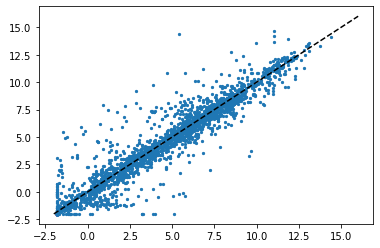

In [14]:
plt.scatter(x=ctdpmur_df['matched_temp'],y=ctdpmur_df['sst'],s=5)
plt.plot([-2,16],[-2,16],'k--')

**FACET PLOTS ABOVE ON:** Season, WaterMass, Time of day (morning or evening), cruise/year, lat/lon

In [15]:
ctdpmur_df.date = pd.to_datetime(ctdpmur_df.date)

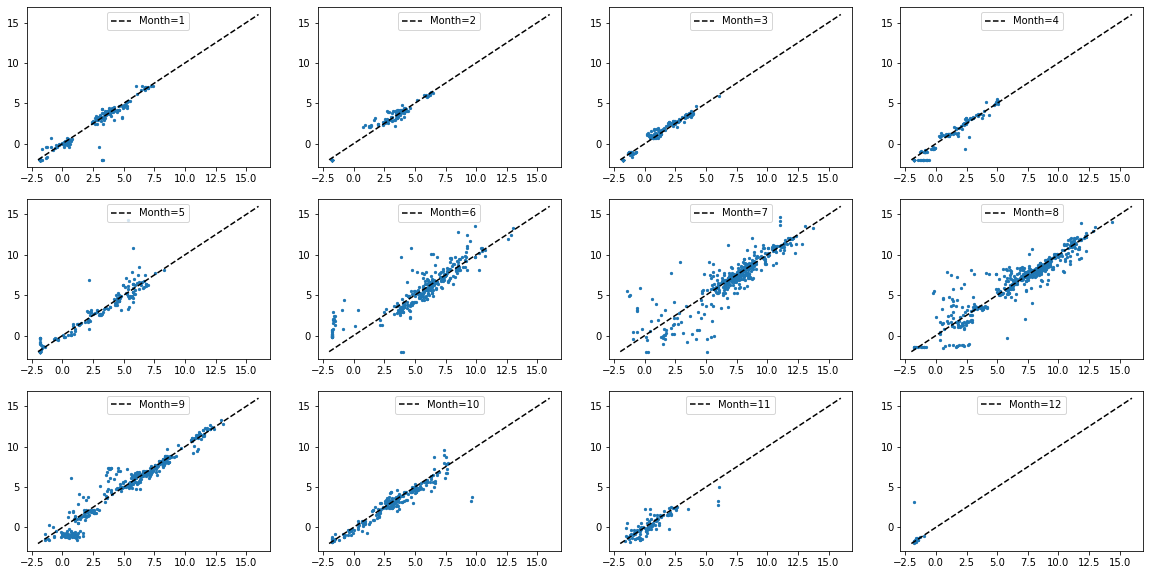

In [17]:
# go by month first
fig, ax = plt.subplots(3,4,figsize=(20, 10))
ax = ax.ravel()

for i in range(1,13,1):
    tmp = ctdpmur_df[ctdpmur_df.date.dt.month == i]
    ax[i-1].scatter(x=tmp['matched_temp'],y=tmp['sst'],s=5)
    ax[i-1].plot([-2,16],[-2,16],'k--',label='Month='+str(i))
    ax[i-1].legend(loc='upper center')

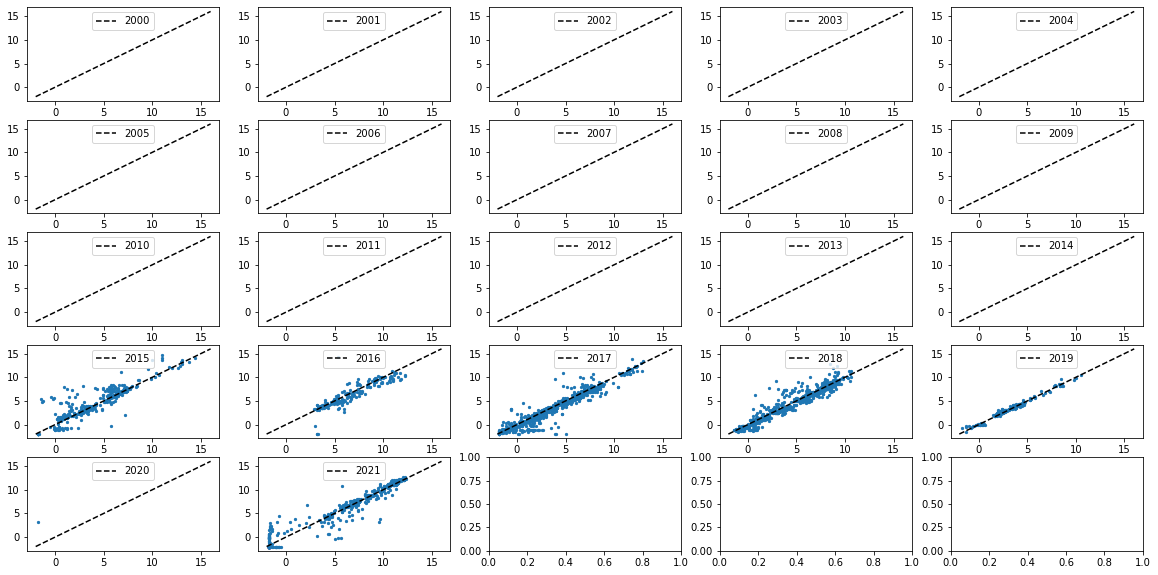

In [22]:
# go by year first
fig, ax = plt.subplots(5,5,figsize=(20, 10))
ax = ax.ravel()

for i in range(2000,2022,1):
    tmp = ctdpmur_df[ctdpmur_df.date.dt.year == i]
    ax[i-2000].scatter(x=tmp['matched_temp'],y=tmp['sst'],s=5)
    ax[i-2000].plot([-2,16],[-2,16],'k--',label=str(i))
    ax[i-2000].legend(loc='upper center')

### Plot locations of Stations

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


In [20]:
# and setup the plot boundaries given the region
extent=[-180, -150, 52.5, 72]

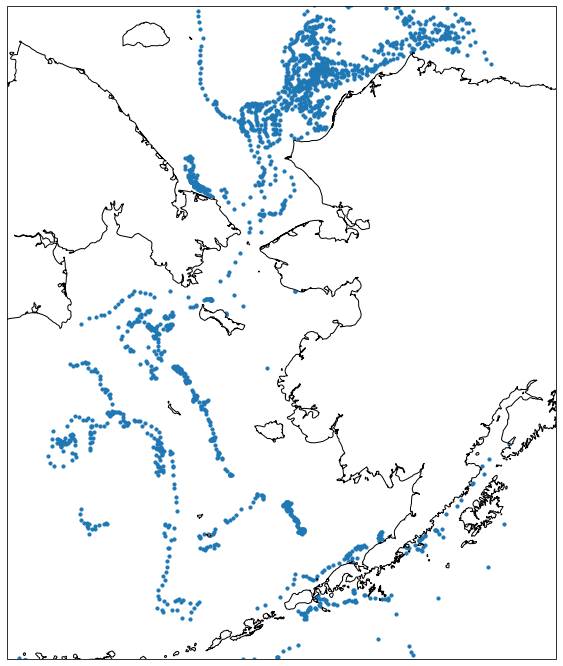

In [21]:
#this is fast if topo is turned off
with_topo = False

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

if with_topo:
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, 
                bathy_sub.topo, cmap=cmocean.cm.gray,
                vmin=-3000,vmax=100,
                transform=transformation)
c = ax.scatter(ctdpmur_df.longitude, ctdpmur_df.latitude, s=10,
                               transform=transformation)
#plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
        

### Split on Water Mass (GOA,BS,Arctic)

- use Bering Strait
- Bristol Bay armpit

(-2.5, 17.5)

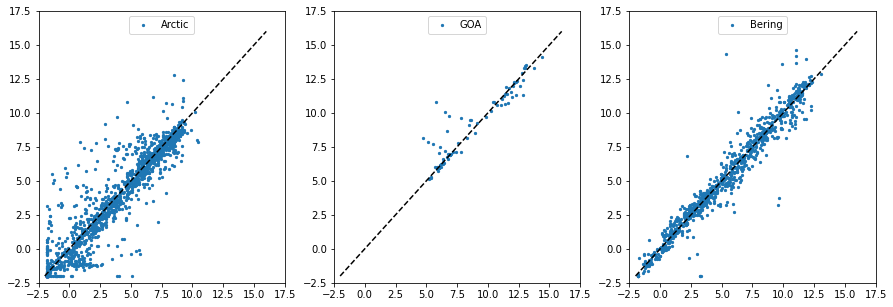

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax = ax.ravel()

65.71131944029068, -169.10629173073403
tmp = ctdpmur_df[ctdpmur_df.latitude >= 65.7]
ax[0].scatter(x=tmp['matched_temp'],y=tmp['sst'],s=5,label='Arctic')
ax[0].plot([-2,16],[-2,16],'k--')
ax[0].legend(loc='upper center')
ax[0].set_xlim([-2.5,17.5])
ax[0].set_ylim([-2.5,17.5])

58.46914699788629, -157.59261991946437
tmp = ctdpmur_df[(ctdpmur_df.lon360 >= 202) & (ctdpmur_df.latitude <= 65.7)]
ax[1].scatter(x=tmp['matched_temp'],y=tmp['sst'],s=5,label='GOA')
ax[1].plot([-2,16],[-2,16],'k--')
ax[1].legend(loc='upper center')
ax[1].set_xlim([-2.5,17.5])
ax[1].set_ylim([-2.5,17.5])

tmp = ctdpmur_df[(ctdpmur_df.lon360 <= 202) & (ctdpmur_df.latitude <= 65.7)]
ax[2].scatter(x=tmp['matched_temp'],y=tmp['sst'],s=5,label='Bering')
ax[2].plot([-2,16],[-2,16],'k--')
ax[2].legend(loc='upper center')
ax[2].set_xlim([-2.5,17.5])
ax[2].set_ylim([-2.5,17.5])

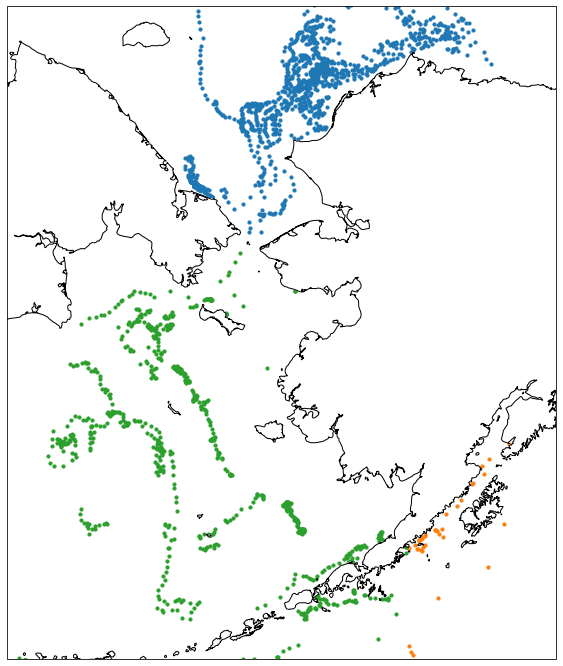

In [30]:
#this is fast if topo is turned off
with_topo = False

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

if with_topo:
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, 
                bathy_sub.topo, cmap=cmocean.cm.gray,
                vmin=-3000,vmax=100,
                transform=transformation)
    
tmp = ctdpmur_df[ctdpmur_df.latitude >= 65.7]
c = ax.scatter(tmp.lon360, tmp.latitude, s=10,
                               transform=transformation)
tmp = ctdpmur_df[(ctdpmur_df.lon360 >= 202) & (ctdpmur_df.latitude <= 65.7)]
c = ax.scatter(tmp.lon360, tmp.latitude, s=10,
                               transform=transformation)
tmp = ctdpmur_df[(ctdpmur_df.lon360 <= 202) & (ctdpmur_df.latitude <= 65.7)]
c = ax.scatter(tmp.lon360, tmp.latitude, s=10,
                               transform=transformation)

#plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
        